In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision
import torch 

In [2]:
data = np.loadtxt("./mnist_train_small.csv", delimiter=",")
data.shape

(20000, 785)

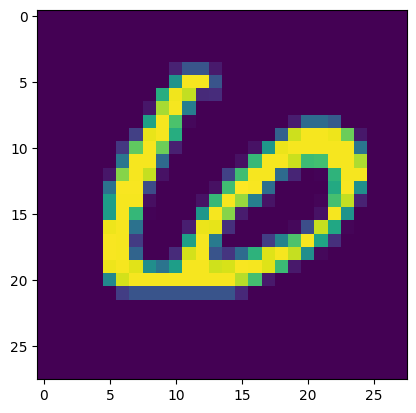

In [3]:
labels = data[:, 0]
imgs = data[:, 1:].reshape(-1, 28, 28)
plt.imshow(imgs[0])

In [4]:
from torch.utils.data import DataLoader, Dataset

class MnistDataset(Dataset):
    def __init__(self):
        data = np.loadtxt("./mnist_train_small.csv", delimiter=",")
        imgs = data[:, 1:].reshape(-1, 28, 28)
        labels = data[:, 0]
        self.imgs = imgs
        self.labels = labels
    
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        return self.imgs[idx], self.labels[idx]

In [5]:
dataset = MnistDataset()

In [6]:
sample_img, sample_label = dataset[0]
sample_img.shape, sample_label

((28, 28), 6.0)

In [7]:
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [8]:
import torch.nn.functional as F

In [13]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 16, 3, 1, 1)
        self.relu = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(16, 10, kernel_size=3)
        self.fc = torch.nn.Linear(10 * 26 * 26, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        # x = x.reshape(x.shape[0], x.shape[1], -1).mean(-1)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return F.log_softmax(x)
    
model = Model().cuda()
model

Model(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (conv2): Conv2d(16, 10, kernel_size=(3, 3), stride=(1, 1))
  (fc): Linear(in_features=6760, out_features=10, bias=True)
)

C:\Users\learn\AppData\Local\Temp\ipykernel_22652\740070699.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


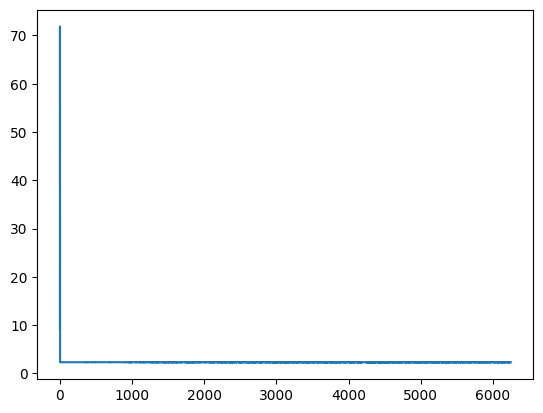

In [14]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss_curve = []
for i in range(5):
    for batch in dataloader:
        imgs, labels = batch
        imgs = imgs[:, None]
        y = model(imgs.float().cuda())
        loss = loss_fn(y, labels.cuda().long())
        optimizer.zero_grad()
        loss.backward()
        loss_curve.append(loss.item())
        optimizer.step()
plt.plot(loss_curve)